In [13]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

import pandas as pd
import numpy as np
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import clone
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# =========================
# 0) Carga
# =========================
parquet_clean = r"C:\PROY_FINAL_ML\data\processed\cba_clean.parquet"

df = pd.read_parquet(parquet_clean)

# Asegurar nombres
col_producto = "producto_std" if "producto_std" in df.columns else "producto"
col_present  = "presentacion" if "presentacion" in df.columns else ("medida" if "medida" in df.columns else None)
col_cadena   = "cadena" if "cadena" in df.columns else None

# Asegurar que la columna es tipo datetime mensual
df["anio_mes"] = pd.to_datetime(df["anio_mes"])
df = df.sort_values(["anio_mes", col_producto, "establecimiento"]).reset_index(drop=True)

In [3]:
# =========================
# 1) Ingeniería de características
# =========================
grp_keys = [col_producto, "establecimiento"]

def add_time_features(g):
    g = g.sort_values("anio_mes").copy()
    # Lags
    for L in [1, 3, 6]:
        g[f"lag_{L}"] = g["precio"].shift(L)
    # Moving Averages y Volatilidades
    g["MA_3"]  = g["precio"].rolling(window=3, min_periods=1).mean()
    g["MA_6"]  = g["precio"].rolling(window=6, min_periods=1).mean()
    g["VOL_3"] = g["precio"].rolling(window=3, min_periods=2).std()
    g["VOL_6"] = g["precio"].rolling(window=6, min_periods=2).std()
    # Objetivo de regresión: precio del próximo mes
    g["y_next"] = g["precio"].shift(-1)
    # % cambio al próximo mes y alerta (clasificación)
    g["pct_change_next"] = (g["y_next"] - g["precio"]) / g["precio"]
    g["alert_next"] = (g["pct_change_next"] >= 0.05).astype("Int64")
    return g

df = df.groupby(grp_keys, group_keys=False).apply(add_time_features)

# Mediana mensual por producto
med_mensual = (
    df.groupby([col_producto, "anio_mes"])["precio"]
      .median()
      .rename("mediana_prod_mes")
      .reset_index()
)
df = df.merge(med_mensual, on=[col_producto, "anio_mes"], how="left")
df["ratio_precio_mediana"] = df["precio"] / df["mediana_prod_mes"]

# Variables temporales
df["year"] = df["anio_mes"].dt.year
df["month"] = df["anio_mes"].dt.month

# Quitamos filas sin objetivo
df_model = df.dropna(subset=["y_next"]).copy()

In [4]:
# =========================
# 2) Conjuntos Train / Valid / Test por tiempo
# =========================
# Reglas: train < valid < test
dates_sorted = np.sort(df_model["anio_mes"].unique())
if len(dates_sorted) < 6:
    # Con pocos meses, hacemos 50% / 25% / 25%
    n = len(dates_sorted)
    cut1 = dates_sorted[int(n*0.5)]
    cut2 = dates_sorted[int(n*0.75)]
else:
    # 60% / 20% / 20%
    n = len(dates_sorted)
    cut1 = dates_sorted[int(n*0.6)]
    cut2 = dates_sorted[int(n*0.8)]

train = df_model[df_model["anio_mes"] < cut1]
valid = df_model[(df_model["anio_mes"] >= cut1) & (df_model["anio_mes"] < cut2)]
test  = df_model[df_model["anio_mes"] >= cut2]

print("Cortes temporales:")
print("Train hasta:", train["anio_mes"].max())
print("Valid:", valid["anio_mes"].min(), "→", valid["anio_mes"].max())
print("Test desde:", test["anio_mes"].min())

Cortes temporales:
Train hasta: 2021-10-01 00:00:00
Valid: 2021-11-01 00:00:00 → 2022-01-01 00:00:00
Test desde: 2022-02-01 00:00:00


In [5]:
# =========================
# 3) Baselines (lag 1, 3 y 6)sfsfdsdfgashdfa
# =========================
for L in [3, 6]:
    col = f"lag_{L}"
    if col not in df_model.columns:
        df_model[col] = df_model.groupby(grp_keys)["precio"].shift(L)

train_copy = train.copy()
valid_copy = valid.copy()
test_copy  = test.copy()

# Asignar lags a cada subconjunto
for L in [3, 6]:
    col = f"lag_{L}"
    train_copy[col] = df_model.loc[train_copy.index, col]
    valid_copy[col] = df_model.loc[valid_copy.index, col]
    test_copy[col]  = df_model.loc[test_copy.index, col]

# Funciones métricas seguras
def safe_rmse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return float(np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2)))

def safe_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return float(np.mean(np.abs(y_true[mask] - y_pred[mask])))

# Evaluar baselines con lag 1 (naive), lag 3 y lag 6
for part_name, part in [("TRAIN", train_copy), ("VALID", valid_copy), ("TEST", test_copy)]:
    y_true = part["y_next"].values

    # Baseline naive (lag 1)
    y_hat_lv = part["precio"].values
    print(f"[{part_name}] Baseline LV (lag 1) → RMSE: {safe_rmse(y_true, y_hat_lv):.4f} | MAE: {safe_mae(y_true, y_hat_lv):.4f}")

    # Baseline estacionales lag 3 y 6
    for L in [3, 6]:
        col = f"lag_{L}"
        if part[col].notna().any():
            mask = part[col].notna()
            y_hat = part.loc[mask, col].values
            y_true_masked = part.loc[mask, "y_next"].values
            print(f"[{part_name}] Baseline Estacional lag {L} → RMSE: {safe_rmse(y_true_masked, y_hat):.4f} | MAE: {safe_mae(y_true_masked, y_hat):.4f}")
        else:
            print(f"[{part_name}] Baseline Estacional lag {L} → no disponible")

print("Rango TRAIN:", train["anio_mes"].min(), "a", train["anio_mes"].max())
print("Cantidad meses únicos en TRAIN:", train["anio_mes"].nunique())

[TRAIN] Baseline LV (lag 1) → RMSE: 0.2172 | MAE: 0.0548
[TRAIN] Baseline Estacional lag 3 → RMSE: 0.3294 | MAE: 0.1107
[TRAIN] Baseline Estacional lag 6 → RMSE: 0.3896 | MAE: 0.1379
[VALID] Baseline LV (lag 1) → RMSE: 0.2522 | MAE: 0.0639
[VALID] Baseline Estacional lag 3 → RMSE: 0.3661 | MAE: 0.1191
[VALID] Baseline Estacional lag 6 → RMSE: 0.3909 | MAE: 0.1379
[TEST] Baseline LV (lag 1) → RMSE: 0.3562 | MAE: 0.0943
[TEST] Baseline Estacional lag 3 → RMSE: 0.4383 | MAE: 0.1481
[TEST] Baseline Estacional lag 6 → RMSE: 0.4741 | MAE: 0.1647
Rango TRAIN: 2021-01-01 00:00:00 a 2021-10-01 00:00:00
Cantidad meses únicos en TRAIN: 10


In [6]:
# =========================
# 4) Preparación de features y pipelines scikit-learn
# =========================
# Features numéricas y categóricas
num_feats = ["precio", "lag_1", "lag_3", "lag_6", "MA_3", "MA_6", "VOL_3", "VOL_6",
             "ratio_precio_mediana", "mediana_prod_mes", "year", "month"]
cat_feats = [col_producto, "establecimiento"]
if col_present is not None: cat_feats.append(col_present)
if col_cadena is not None:  cat_feats.append(col_cadena)

preproc_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_feats),
        ("cat", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_feats)
    ],
    remainder="drop"
)

preproc_clf = preproc_reg

# Datasets finales
X_train, y_train = train[num_feats + cat_feats], train["y_next"]
X_valid, y_valid = valid[num_feats + cat_feats], valid["y_next"]
X_test,  y_test  = test[num_feats + cat_feats],  test["y_next"]

# Para clasificación (alerta)
y_train_cls = train["alert_next"].fillna(0).astype(int)
y_valid_cls = valid["alert_next"].fillna(0).astype(int)
y_test_cls  = test["alert_next"].fillna(0).astype(int)

In [7]:
# =========================
# 5) Modelos de REGRESIÓN
# =========================
models_reg = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
#    "RFReg": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=None)
    "HGBReg": HistGradientBoostingRegressor(max_iter=300, random_state=42)
}

for name, base in models_reg.items():
    pipe = Pipeline(steps=[("pre", preproc_reg), ("model", base)])
    pipe.fit(X_train, y_train)
    pred_val = pipe.predict(X_valid)
    pred_tst = pipe.predict(X_test)
    print(f"\n[REG:{name}] VALID → RMSE:{np.sqrt(mean_squared_error(y_valid, pred_val)):.4f} | MAE:{mean_absolute_error(y_valid, pred_val):.4f} | R2:{r2_score(y_valid, pred_val):.3f}")
    print(f"[REG:{name}] TEST  → RMSE:{np.sqrt(mean_squared_error(y_test, pred_tst)):.4f} | MAE:{mean_absolute_error(y_test, pred_tst):.4f} | R2:{r2_score(y_test, pred_tst):.3f}")


[REG:Ridge] VALID → RMSE:0.2393 | MAE:0.0834 | R2:0.988
[REG:Ridge] TEST  → RMSE:0.3345 | MAE:0.1126 | R2:0.978

[REG:HGBReg] VALID → RMSE:0.2308 | MAE:0.0782 | R2:0.989
[REG:HGBReg] TEST  → RMSE:0.3331 | MAE:0.1116 | R2:0.978


In [8]:
# =========================
# 6) Modelos de CLASIFICACIÓN (alerta)
# =========================
models_clf = {
    "LogReg": LogisticRegression(max_iter=200, n_jobs=None, class_weight="balanced"),
#    "RFCls": RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced")
    "HGBCls": HistGradientBoostingClassifier(max_iter=300, random_state=42)    
}

for name, base in models_clf.items():
    pipe = Pipeline(steps=[("pre", preproc_clf), ("model", base)])
    pipe.fit(X_train, y_train_cls)
    p_val = pipe.predict(X_valid)
    p_tst = pipe.predict(X_test)
    proba_val = pipe.predict_proba(X_valid)[:,1] if hasattr(pipe["model"], "predict_proba") else p_val
    proba_tst = pipe.predict_proba(X_test)[:,1]  if hasattr(pipe["model"], "predict_proba")  else p_tst
    print(f"\n[CLF:{name}] VALID → Acc:{accuracy_score(y_valid_cls, p_val):.3f} | F1:{f1_score(y_valid_cls, p_val):.3f} | ROC-AUC:{roc_auc_score(y_valid_cls, proba_val):.3f}")
    print(f"[CLF:{name}] TEST  → Acc:{accuracy_score(y_test_cls, p_tst):.3f} | F1:{f1_score(y_test_cls, p_tst):.3f} | ROC-AUC:{roc_auc_score(y_test_cls, proba_tst):.3f}")


[CLF:LogReg] VALID → Acc:0.764 | F1:0.380 | ROC-AUC:0.852
[CLF:LogReg] TEST  → Acc:0.740 | F1:0.374 | ROC-AUC:0.806

[CLF:HGBCls] VALID → Acc:0.907 | F1:0.282 | ROC-AUC:0.855
[CLF:HGBCls] TEST  → Acc:0.887 | F1:0.239 | ROC-AUC:0.821


In [9]:
# =========================
# 7) Hyperparameter tuning con validación temporal para Ridge
# =========================
# Definimos funciones métricas
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)
    
# Definimos TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Pipeline para Ridge con preprocesamiento
pipe_ridge = Pipeline([
    ("pre", preproc_reg),
    ("model", Ridge())
])

# Grid de parámetros a probar
param_grid_ridge = {
    "model__alpha": [0.1, 1.0, 10.0, 100.0]
}

# GridSearchCV con validación temporal y métrica RMSE
grid_search_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid_ridge,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros para Ridge con validación temporal...")
grid_search_ridge.fit(X_train, y_train)

print("Mejor alpha:", grid_search_ridge.best_params_["model__alpha"])
print("Mejor score CV (neg MSE):", grid_search_ridge.best_score_)

best_ridge = grid_search_ridge.best_estimator_

y_valid_pred = best_ridge.predict(X_valid)
y_test_pred = best_ridge.predict(X_test)

print(f"[RIDGE] VALID RMSE: {rmse(y_valid, y_valid_pred):.4f} | MAE: {mae(y_valid, y_valid_pred):.4f}")
print(f"[RIDGE] TEST  RMSE: {rmse(y_test, y_test_pred):.4f} | MAE: {mae(y_test, y_test_pred):.4f}")

Iniciando búsqueda de hiperparámetros para Ridge con validación temporal...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejor alpha: 10.0
Mejor score CV (neg MSE): -0.0435198833033349
[RIDGE] VALID RMSE: 0.2399 | MAE: 0.0836
[RIDGE] TEST  RMSE: 0.3342 | MAE: 0.1125


In [10]:
# =========================
# 8) Hyperparameter tuning con validación temporal para HistGradientBoostingRegressor
# =========================
from sklearn.ensemble import HistGradientBoostingRegressor

# Pipeline con preprocesamiento
pipe_hgb = Pipeline([
    ("pre", preproc_reg),
    ("model", HistGradientBoostingRegressor(random_state=42, max_iter=200))
])

# Grid de hiperparámetros
param_grid_hgb = {
    "model__max_depth": [3, 5, None],
    "model__min_samples_leaf": [20, 50],
    "model__learning_rate": [0.01, 0.1]
}

# GridSearchCV con validación temporal
grid_search_hgb = GridSearchCV(
    pipe_hgb,
    param_grid=param_grid_hgb,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

print("Iniciando búsqueda de hiperparámetros para HistGradientBoostingRegressor con validación temporal...")
grid_search_hgb.fit(X_train, y_train)

print("Mejores parámetros:", grid_search_hgb.best_params_)
print("Mejor score CV (neg MSE):", grid_search_hgb.best_score_)

# Evaluación en validación y test con mejor modelo
best_hgb = grid_search_hgb.best_estimator_

y_valid_pred_hgb = best_hgb.predict(X_valid)
y_test_pred_hgb  = best_hgb.predict(X_test)

print(f"[HGB] VALID → RMSE: {rmse(y_valid, y_valid_pred_hgb):.4f} | MAE: {mae(y_valid, y_valid_pred_hgb):.4f}")
print(f"[HGB] TEST  → RMSE: {rmse(y_test, y_test_pred_hgb):.4f} | MAE: {mae(y_test, y_test_pred_hgb):.4f}")

Iniciando búsqueda de hiperparámetros para HistGradientBoostingRegressor con validación temporal...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_leaf': 20}
Mejor score CV (neg MSE): -0.043840843719568735
[HGB] VALID → RMSE: 0.2339 | MAE: 0.0792
[HGB] TEST  → RMSE: 0.3345 | MAE: 0.1123


In [11]:
# =========================
# Guardar modelos y preprocesadores

# 1️Modelos de regresión
joblib.dump(best_ridge, "C:/PROY_FINAL_ML/models/best_ridge.pkl")
joblib.dump(best_hgb, "C:/PROY_FINAL_ML/models/best_hgb.pkl")

# Modelos de clasificación
joblib.dump(pipe, "C:/PROY_FINAL_ML/models/best_hgb_clf.pkl")

# Preprocesadores
joblib.dump(preproc_reg, "C:/PROY_FINAL_ML/models/preproc_reg.pkl")
joblib.dump(preproc_clf, "C:/PROY_FINAL_ML/models/preproc_clf.pkl")

# Conjuntos de datos
joblib.dump(X_train, "C:/PROY_FINAL_ML/data/processed/X_train.pkl")
joblib.dump(X_valid, "C:/PROY_FINAL_ML/data/processed/X_valid.pkl")
joblib.dump(X_test,  "C:/PROY_FINAL_ML/data/processed/X_test.pkl")

joblib.dump(y_train, "C:/PROY_FINAL_ML/data/processed/y_train.pkl")
joblib.dump(y_valid, "C:/PROY_FINAL_ML/data/processed/y_valid.pkl")
joblib.dump(y_test,  "C:/PROY_FINAL_ML/data/processed/y_test.pkl")

# Clasificación
joblib.dump(y_train_cls, "C:/PROY_FINAL_ML/data/processed/y_train_cls.pkl")
joblib.dump(y_valid_cls, "C:/PROY_FINAL_ML/data/processed/y_valid_cls.pkl")
joblib.dump(y_test_cls,  "C:/PROY_FINAL_ML/data/processed/y_test_cls.pkl")

# Guardar lista de features
num_feats = ["precio", "lag_1", "lag_3", "lag_6", "MA_3", "MA_6", "VOL_3", "VOL_6",
             "ratio_precio_mediana", "mediana_prod_mes", "year", "month"]

cat_feats = ["producto_std", "establecimiento", "presentacion", "cadena"]

joblib.dump(num_feats, "C:/PROY_FINAL_ML/data/processed/num_feats.pkl")
joblib.dump(cat_feats, "C:/PROY_FINAL_ML/data/processed/cat_feats.pkl")

print("Datasets y features guardados en 'data/processed'.")
print("Todos los modelos y preprocesadores se han guardado correctamente en 'models'.")

Datasets y features guardados en 'data/processed'.
Todos los modelos y preprocesadores se han guardado correctamente en 'models'.


In [ ]:
#--------------------------------------------------------------------------------------------------------------------
# PRUEBAS DE PREDICCIONES
#--------------------------------------------------------------------------------------------------------------------

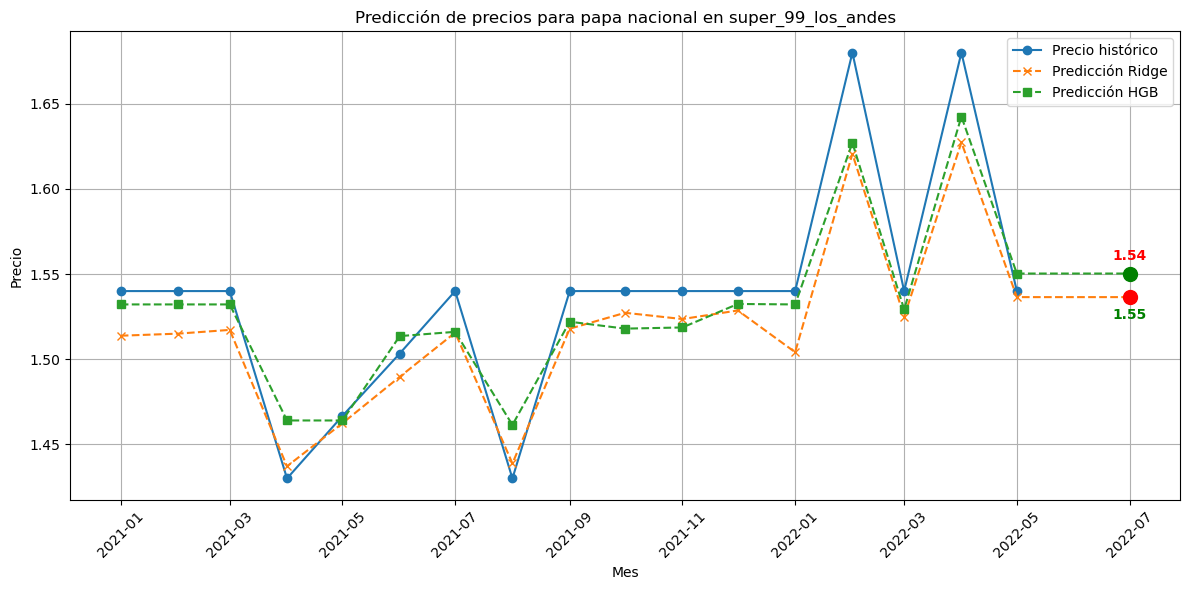

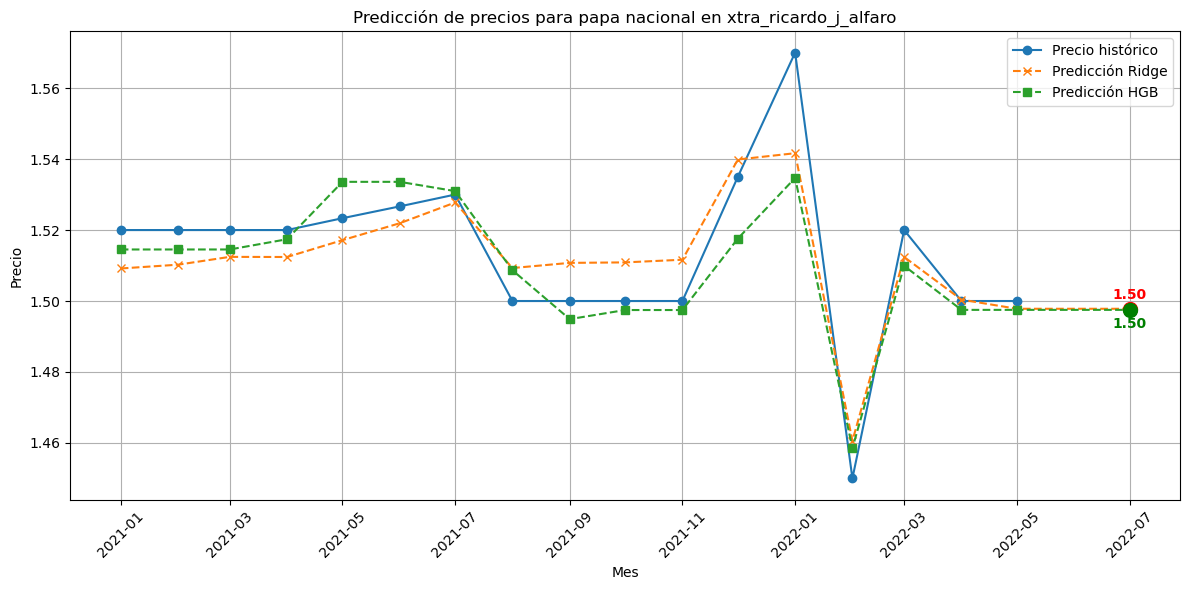

In [25]:
#--------------------------------------------------------------------------------------------------------------------
# PREDICCION DE PRECIOS PARA UN ESTABLECIMIENTO DEFINIDIO
#--------------------------------------------------------------------------------------------------------------------

# Cargar modelos/pipelines guardados
best_ridge = joblib.load("C:/PROY_FINAL_ML/models/best_ridge.pkl")
best_hgb   = joblib.load("C:/PROY_FINAL_ML/models/best_hgb.pkl")

#(PAPA NACIONAL - SP 99 -LOS ANDES)
# Seleccionar producto y establecimiento
producto_sel = "papa nacional"          # colocamos el producto a predecir
establecimiento_sel = "super_99_los_andes"  # establecimiento a predecir 

df_prod_est = df_model[
    (df_model[col_producto] == producto_sel) &
    (df_model["establecimiento"] == establecimiento_sel)
].copy()

# Predicción histórica con pipelines
y_pred_ridge = best_ridge.predict(df_prod_est)
y_pred_hgb   = best_hgb.predict(df_prod_est)

# Predicción para mes 2022-07
last_row = df_prod_est.iloc[-1].copy()
last_row["anio_mes"] = pd.to_datetime("2022-07-01")

X_next = pd.DataFrame([last_row])
y_next_ridge = best_ridge.predict(X_next)[0]
y_next_hgb   = best_hgb.predict(X_next)[0]

# Crear DataFrame para graficar
df_plot = df_prod_est.copy()
df_plot["pred_ridge"] = y_pred_ridge
df_plot["pred_hgb"]   = y_pred_hgb

# Añadir predicción julio 2022
df_plot = pd.concat([
    df_plot,
    pd.DataFrame({
        "anio_mes": [pd.to_datetime("2022-07-01")],
        "precio": [None],
        "pred_ridge": [y_next_ridge],
        "pred_hgb": [y_next_hgb]
    })
], ignore_index=True)


# Graficar histórico + predicción
plt.figure(figsize=(12,6))
plt.plot(df_plot["anio_mes"], df_plot["precio"], marker='o', label="Precio histórico")
plt.plot(df_plot["anio_mes"], df_plot["pred_ridge"], marker='x', linestyle='--', label="Predicción Ridge")
plt.plot(df_plot["anio_mes"], df_plot["pred_hgb"], marker='s', linestyle='--', label="Predicción HGB")

# Destacar la predicción de julio
plt.scatter(pd.to_datetime("2022-07-01"), y_next_ridge, color='red', s=100, zorder=5)
plt.scatter(pd.to_datetime("2022-07-01"), y_next_hgb, color='green', s=100, zorder=5)

# Añadir etiquetas con valor
plt.text(pd.to_datetime("2022-07-01"), y_next_ridge + 0.02, f"{y_next_ridge:.2f}", 
         color='red', fontsize=10, fontweight='bold', ha='center', va='bottom')
plt.text(pd.to_datetime("2022-07-01"), y_next_hgb - 0.02, f"{y_next_hgb:.2f}", 
         color='green', fontsize=10, fontweight='bold', ha='center', va='top')

plt.title(f"Predicción de precios para {producto_sel} en {establecimiento_sel}")
plt.xlabel("Mes")
plt.ylabel("Precio")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(["Precio histórico", "Predicción Ridge", "Predicción HGB"])
plt.tight_layout()
plt.show()


#-----------------------------------------------------------------------------------------------------------------------
#(PAPA NACIONAL - SUPER XTRA R.ALFARO)

# Seleccionar producto y establecimiento
producto_sel = "papa nacional"          # reemplaza con tu producto
establecimiento_sel = "xtra_ricardo_j_alfaro"  # reemplaza con tu establecimiento

df_prod_est = df_model[
    (df_model[col_producto] == producto_sel) &
    (df_model["establecimiento"] == establecimiento_sel)
].copy()

# Predicción histórica con pipelines
y_pred_ridge = best_ridge.predict(df_prod_est)
y_pred_hgb   = best_hgb.predict(df_prod_est)

# Predicción para mes 2022-07
last_row = df_prod_est.iloc[-1].copy()
last_row["anio_mes"] = pd.to_datetime("2022-07-01")

X_next = pd.DataFrame([last_row])
y_next_ridge = best_ridge.predict(X_next)[0]
y_next_hgb   = best_hgb.predict(X_next)[0]

# Crear DataFrame para graficar
df_plot = df_prod_est.copy()
df_plot["pred_ridge"] = y_pred_ridge
df_plot["pred_hgb"]   = y_pred_hgb

# Añadir predicción julio 2022
df_plot = pd.concat([
    df_plot,
    pd.DataFrame({
        "anio_mes": [pd.to_datetime("2022-07-01")],
        "precio": [None],
        "pred_ridge": [y_next_ridge],
        "pred_hgb": [y_next_hgb]
    })
], ignore_index=True)

# Graficar histórico + predicción
plt.figure(figsize=(12,6))
plt.plot(df_plot["anio_mes"], df_plot["precio"], marker='o', label="Precio histórico")
plt.plot(df_plot["anio_mes"], df_plot["pred_ridge"], marker='x', linestyle='--', label="Predicción Ridge")
plt.plot(df_plot["anio_mes"], df_plot["pred_hgb"], marker='s', linestyle='--', label="Predicción HGB")

# Destacar la predicción de julio
plt.scatter(pd.to_datetime("2022-07-01"), y_next_ridge, color='red', s=100, zorder=5)
plt.scatter(pd.to_datetime("2022-07-01"), y_next_hgb, color='green', s=100, zorder=5)

# Añadir etiquetas con valor
plt.text(pd.to_datetime("2022-07-01"), y_next_ridge + 0.002, f"{y_next_ridge:.2f}", 
         color='red', fontsize=10, fontweight='bold', ha='center', va='bottom')
plt.text(pd.to_datetime("2022-07-01"), y_next_hgb - 0.002, f"{y_next_hgb:.2f}", 
         color='green', fontsize=10, fontweight='bold', ha='center', va='top')

plt.title(f"Predicción de precios para {producto_sel} en {establecimiento_sel}")
plt.xlabel("Mes")
plt.ylabel("Precio")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(["Precio histórico", "Predicción Ridge", "Predicción HGB"])
plt.tight_layout()
plt.show()

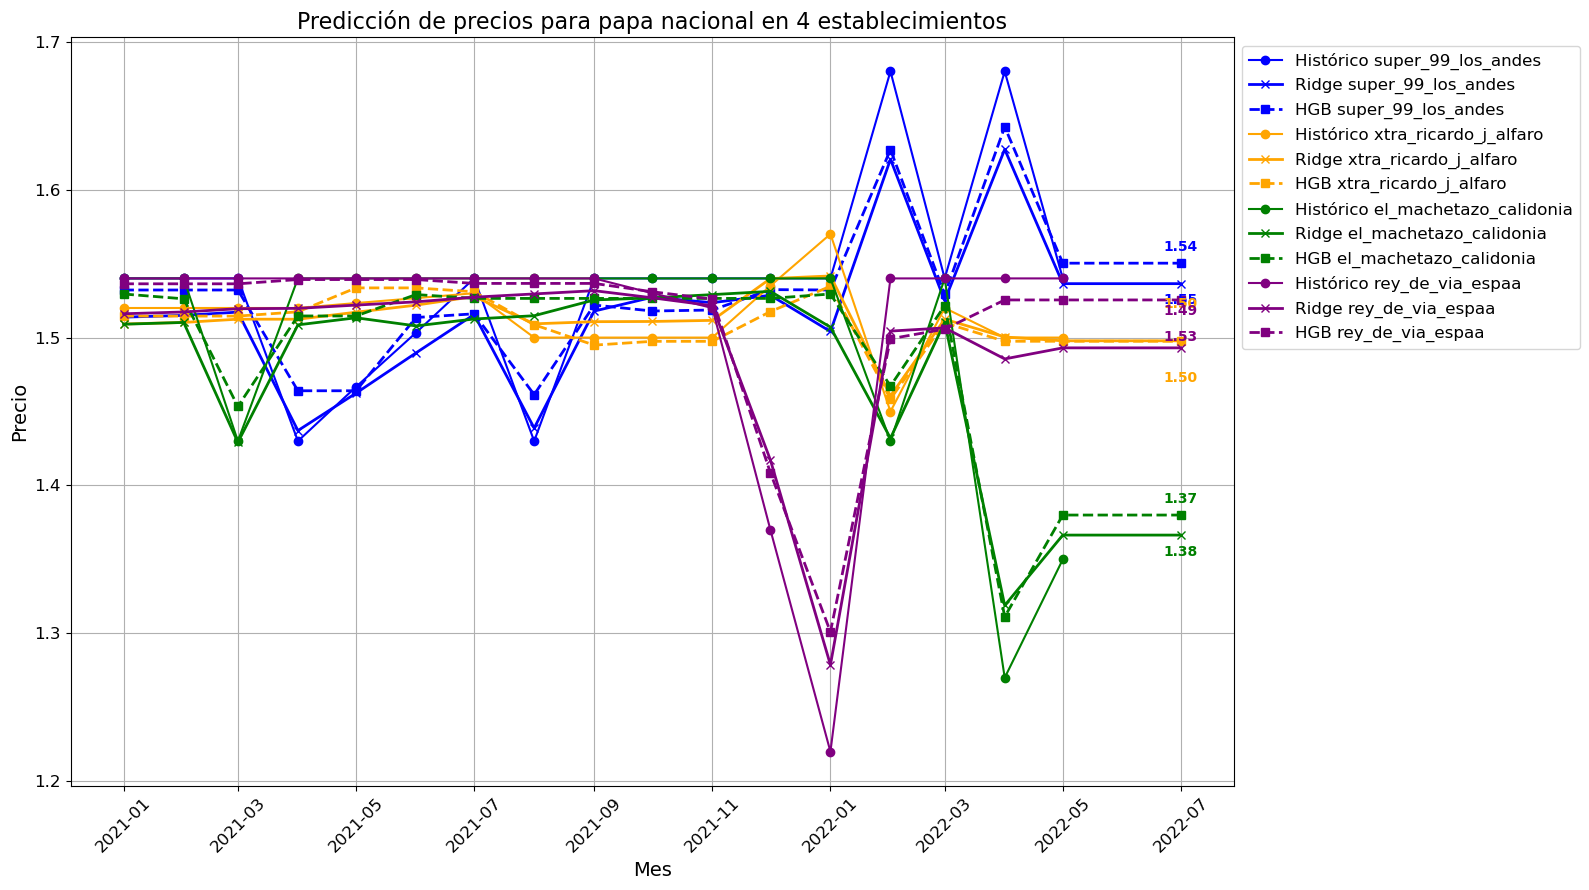

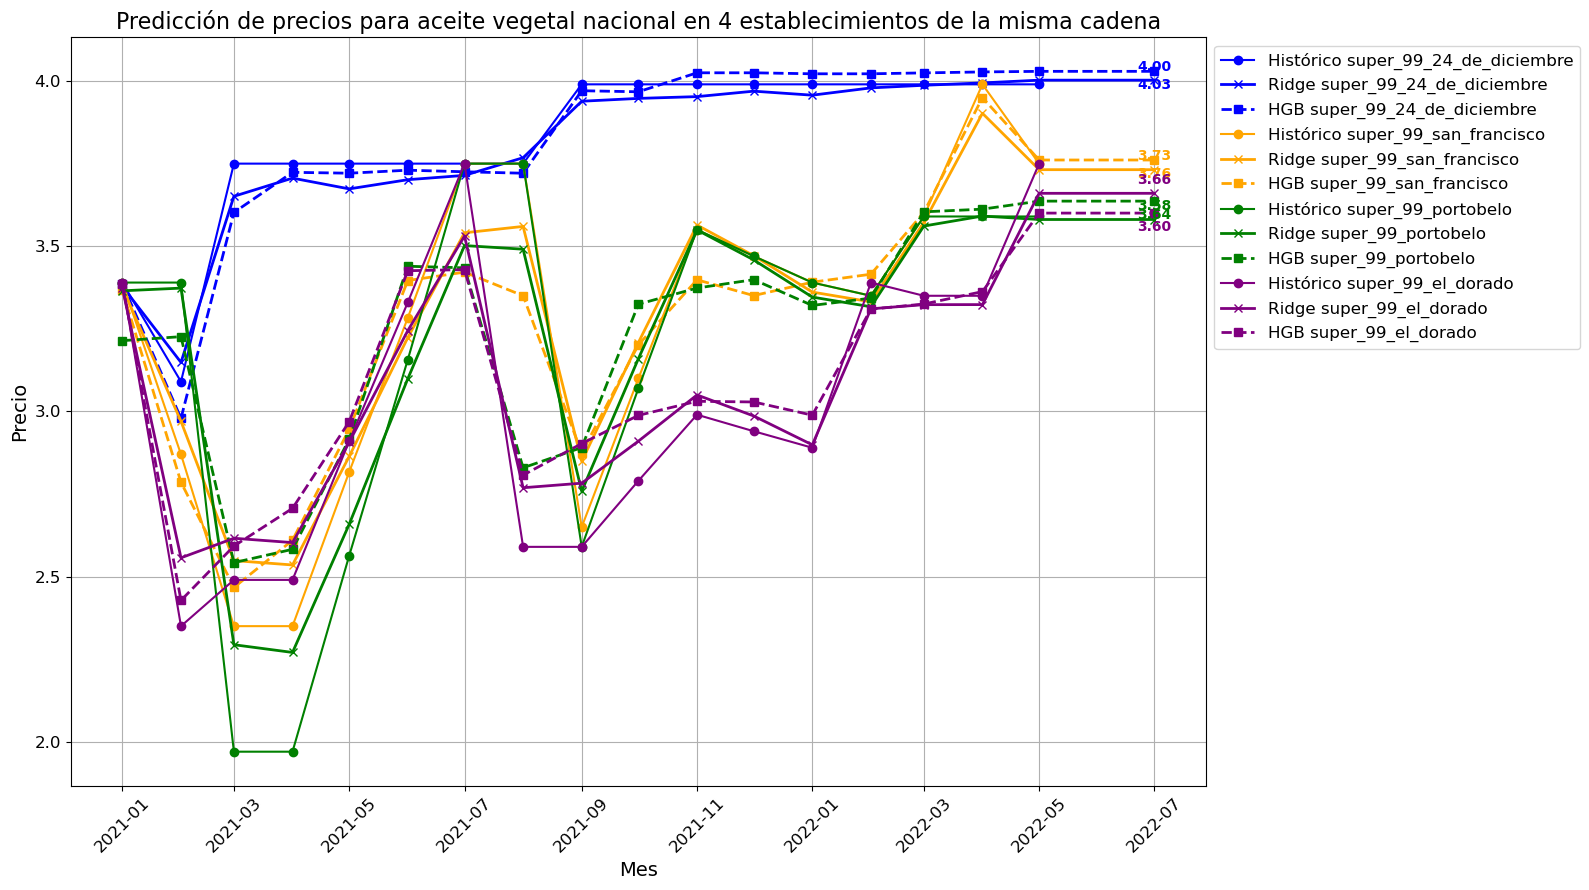

In [26]:
#--------------------------------------------------------------------------------------------------------------------
# PREDICCION DE PRECIOS PARA UN 4 ESTABLECIMIENTOS
#--------------------------------------------------------------------------------------------------------------------
# -----------------------------
# Cargar modelos/pipelines guardados
# -----------------------------
#best_ridge = joblib.load("C:/PROY_FINAL_ML/models/best_ridge.pkl")
#best_hgb   = joblib.load("C:/PROY_FINAL_ML/models/best_hgb.pkl")

# Producto y lista de establecimientos PAPAS
establecimientos = [
    "super_99_los_andes",
    "xtra_ricardo_j_alfaro",
    "el_machetazo_calidonia",
    "rey_de_via_espaa"
]

# Colores base para cada establecimiento
colores = ['blue', 'orange', 'green', 'purple']

# Figura más grande
plt.figure(figsize=(16,9))

# Iterar sobre cada establecimiento
for i, est in enumerate(establecimientos):
    df_prod_est = df_model[
        (df_model[col_producto] == producto_sel) & 
        (df_model["establecimiento"] == est)
    ].copy()
    
    if df_prod_est.empty:
        continue
    
    # Predicción histórica
    y_pred_ridge = best_ridge.predict(df_prod_est)
    y_pred_hgb   = best_hgb.predict(df_prod_est)
    
    # Predicción mes 2022-07
    last_row = df_prod_est.iloc[-1].copy()
    last_row["anio_mes"] = pd.to_datetime("2022-07-01")
    X_next = pd.DataFrame([last_row])
    y_next_ridge = best_ridge.predict(X_next)[0]
    y_next_hgb   = best_hgb.predict(X_next)[0]
    
    # Crear DataFrame para graficar
    df_plot = df_prod_est.copy()
    df_plot["pred_ridge"] = y_pred_ridge
    df_plot["pred_hgb"]   = y_pred_hgb
    df_plot = pd.concat([
        df_plot,
        pd.DataFrame({
            "anio_mes": [pd.to_datetime("2022-07-01")],
            "precio": [None],
            "pred_ridge": [y_next_ridge],
            "pred_hgb": [y_next_hgb]
        })
    ], ignore_index=True)
    
    # Graficar histórico
    plt.plot(df_plot["anio_mes"], df_plot["precio"], marker='o', linestyle='-', color=colores[i], label=f"Histórico {est}")
    
    # Graficar predicción Ridge y HGB con diferentes estilos
    plt.plot(df_plot["anio_mes"], df_plot["pred_ridge"], marker='x', linestyle='-', color=colores[i], linewidth=2, label=f"Ridge {est}")
    plt.plot(df_plot["anio_mes"], df_plot["pred_hgb"], marker='s', linestyle='--', color=colores[i], linewidth=2, label=f"HGB {est}")
    
    # Etiquetas julio 2022
    plt.text(pd.to_datetime("2022-07-01"), y_next_ridge + 0.02, f"{y_next_ridge:.2f}", 
             color=colores[i], fontsize=10, fontweight='bold', ha='center', va='bottom')
    plt.text(pd.to_datetime("2022-07-01"), y_next_hgb - 0.02, f"{y_next_hgb:.2f}", 
             color=colores[i], fontsize=10, fontweight='bold', ha='center', va='top')

# Configuración del gráfico
plt.title(f"Predicción de precios para {producto_sel} en 4 establecimientos", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Precio", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Leyenda fuera del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=12)

plt.tight_layout()
plt.show()

# ----------------------------------------------
# Producto y lista de establecimientos

producto_sel = "aceite vegetal nacional"
establecimientos = [
    "super_99_24_de_diciembre",
    "super_99_san_francisco",
    "super_99_portobelo",
    "super_99_el_dorado"
]

# Colores base para cada establecimiento
colores = ['blue', 'orange', 'green', 'purple']

# Figura más grande
plt.figure(figsize=(16,9))

# Iterar sobre cada establecimiento
for i, est in enumerate(establecimientos):
    df_prod_est = df_model[
        (df_model[col_producto] == producto_sel) & 
        (df_model["establecimiento"] == est)
    ].copy()
    
    if df_prod_est.empty:
        continue
    
    # Predicción histórica
    y_pred_ridge = best_ridge.predict(df_prod_est)
    y_pred_hgb   = best_hgb.predict(df_prod_est)
    
    # Predicción mes 2022-07
    last_row = df_prod_est.iloc[-1].copy()
    last_row["anio_mes"] = pd.to_datetime("2022-07-01")
    X_next = pd.DataFrame([last_row])
    y_next_ridge = best_ridge.predict(X_next)[0]
    y_next_hgb   = best_hgb.predict(X_next)[0]
    
    # Crear DataFrame para graficar
    df_plot = df_prod_est.copy()
    df_plot["pred_ridge"] = y_pred_ridge
    df_plot["pred_hgb"]   = y_pred_hgb
    df_plot = pd.concat([
        df_plot,
        pd.DataFrame({
            "anio_mes": [pd.to_datetime("2022-07-01")],
            "precio": [None],
            "pred_ridge": [y_next_ridge],
            "pred_hgb": [y_next_hgb]
        })
    ], ignore_index=True)
    
    # Graficar histórico
    plt.plot(df_plot["anio_mes"], df_plot["precio"], marker='o', linestyle='-', color=colores[i], label=f"Histórico {est}")
    
    # Graficar predicción Ridge y HGB con diferentes estilos
    plt.plot(df_plot["anio_mes"], df_plot["pred_ridge"], marker='x', linestyle='-', color=colores[i], linewidth=2, label=f"Ridge {est}")
    plt.plot(df_plot["anio_mes"], df_plot["pred_hgb"], marker='s', linestyle='--', color=colores[i], linewidth=2, label=f"HGB {est}")
    
    # Etiquetas julio 2022
    plt.text(pd.to_datetime("2022-07-01"), y_next_ridge + 0.02, f"{y_next_ridge:.2f}", 
             color=colores[i], fontsize=10, fontweight='bold', ha='center', va='bottom')
    plt.text(pd.to_datetime("2022-07-01"), y_next_hgb - 0.02, f"{y_next_hgb:.2f}", 
             color=colores[i], fontsize=10, fontweight='bold', ha='center', va='top')

# Configuración del gráfico
plt.title(f"Predicción de precios para {producto_sel} en 4 establecimientos de la misma cadena", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Precio", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Leyenda fuera del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=12)

plt.tight_layout()
plt.show()



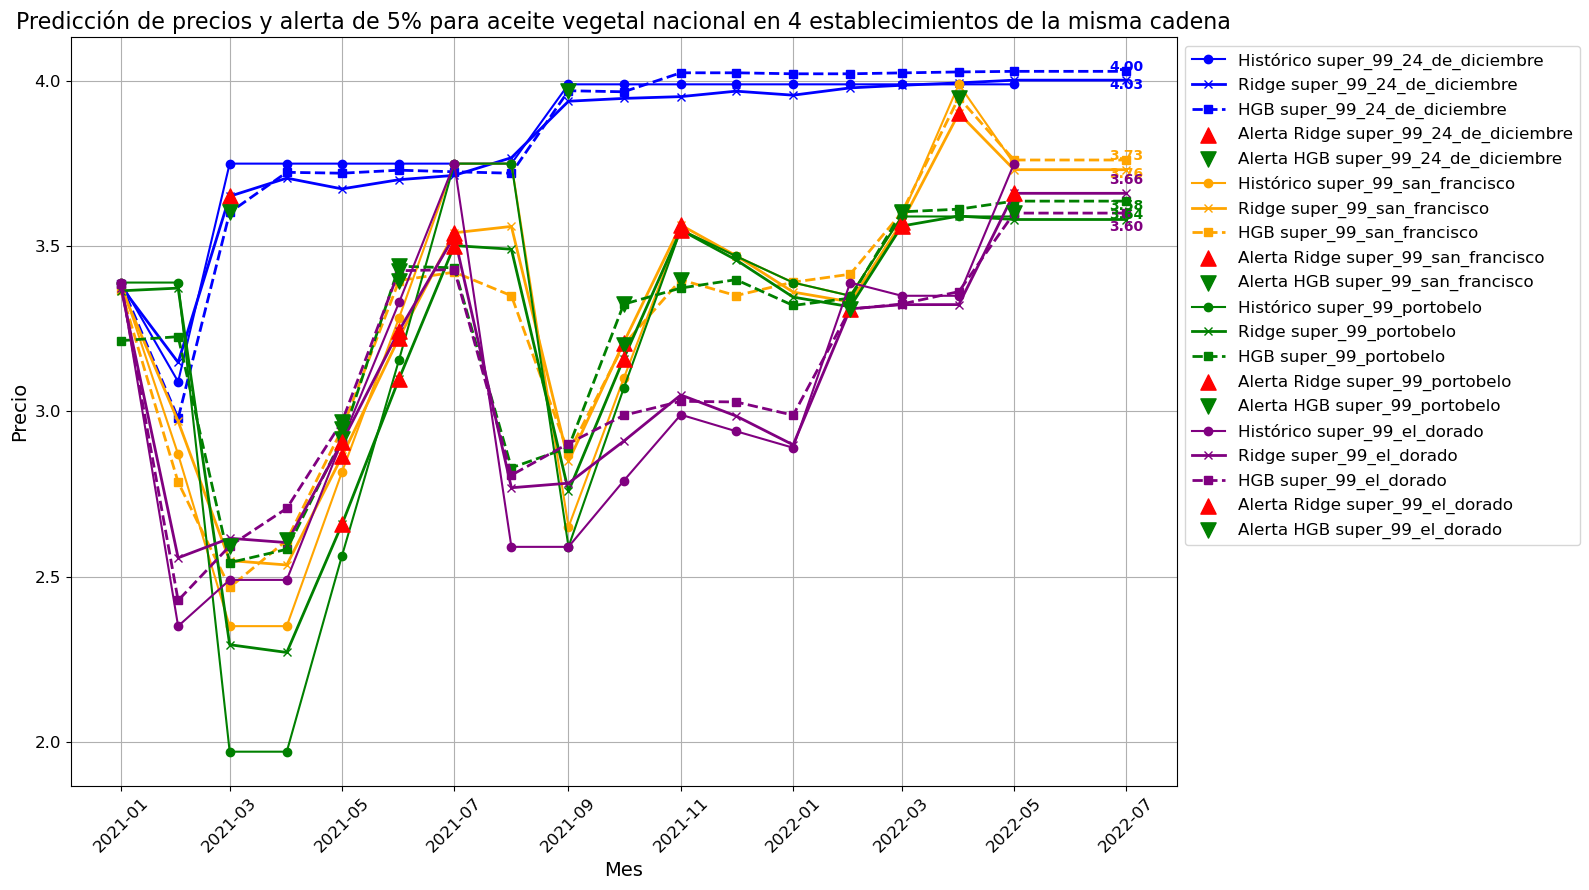

In [27]:
#--------------------------------------------------------------------------------------------------------------------
# ALERTAS DE PRECIOS PARA UN 4 ESTABLECIMIENTOS
#--------------------------------------------------------------------------------------------------------------------
# Producto y lista de establecimientos
producto_sel = "aceite vegetal nacional"
establecimientos = [
    "super_99_24_de_diciembre",
    "super_99_san_francisco",
    "super_99_portobelo",
    "super_99_el_dorado"
]

# Colores base para cada establecimiento
colores = ['blue', 'orange', 'green', 'purple']

# Umbral de alerta (ej. 2%)
umbral = 0.05

# Figura más grande
plt.figure(figsize=(16,9))

# Iterar sobre cada establecimiento
for i, est in enumerate(establecimientos):
    df_prod_est = df_model[
        (df_model[col_producto] == producto_sel) & 
        (df_model["establecimiento"] == est)
    ].copy()
    
    if df_prod_est.empty:
        continue
    
    # Predicción histórica
    y_pred_ridge = best_ridge.predict(df_prod_est)
    y_pred_hgb   = best_hgb.predict(df_prod_est)
    
    # Predicción mes 2022-07
    last_row = df_prod_est.iloc[-1].copy()
    last_row["anio_mes"] = pd.to_datetime("2022-07-01")
    X_next = pd.DataFrame([last_row])
    y_next_ridge = best_ridge.predict(X_next)[0]
    y_next_hgb   = best_hgb.predict(X_next)[0]
    
    # Crear DataFrame para graficar
    df_plot = df_prod_est.copy()
    df_plot["pred_ridge"] = y_pred_ridge
    df_plot["pred_hgb"]   = y_pred_hgb
    df_plot = pd.concat([
        df_plot,
        pd.DataFrame({
            "anio_mes": [pd.to_datetime("2022-07-01")],
            "precio": [None],
            "pred_ridge": [y_next_ridge],
            "pred_hgb": [y_next_hgb]
        })
    ], ignore_index=True)
    
    # Calcular % cambio y alertas para todos los meses
    df_plot["pct_change_ridge"] = df_plot["pred_ridge"].pct_change()
    df_plot["alerta_ridge"] = (df_plot["pct_change_ridge"] >= umbral).astype(int)

    df_plot["pct_change_hgb"] = df_plot["pred_hgb"].pct_change()
    df_plot["alerta_hgb"] = (df_plot["pct_change_hgb"] >= umbral).astype(int)
    
    # Graficar histórico
    plt.plot(df_plot["anio_mes"], df_plot["precio"], marker='o', linestyle='-', color=colores[i], label=f"Histórico {est}")
    
    # Graficar predicción Ridge y HGB
    plt.plot(df_plot["anio_mes"], df_plot["pred_ridge"], marker='x', linestyle='-', color=colores[i], linewidth=2, label=f"Ridge {est}")
    plt.plot(df_plot["anio_mes"], df_plot["pred_hgb"], marker='s', linestyle='--', color=colores[i], linewidth=2, label=f"HGB {est}")
    
    # Etiquetas julio 2022
    plt.text(pd.to_datetime("2022-07-01"), y_next_ridge + 0.02, f"{y_next_ridge:.2f}", 
             color=colores[i], fontsize=10, fontweight='bold', ha='center', va='bottom')
    plt.text(pd.to_datetime("2022-07-01"), y_next_hgb - 0.02, f"{y_next_hgb:.2f}", 
             color=colores[i], fontsize=10, fontweight='bold', ha='center', va='top')
    
    # Marcar alertas en todos los meses
    alertas_ridge = df_plot[df_plot["alerta_ridge"] == 1]
    alertas_hgb   = df_plot[df_plot["alerta_hgb"] == 1]

    plt.scatter(alertas_ridge["anio_mes"], alertas_ridge["pred_ridge"], color="red", marker="^", s=120, label=f"Alerta Ridge {est}", zorder=6)
    plt.scatter(alertas_hgb["anio_mes"], alertas_hgb["pred_hgb"], color="green", marker="v", s=120, label=f"Alerta HGB {est}", zorder=6)

# Configuración del gráfico
plt.title(f"Predicción de precios y alerta de 5% para {producto_sel} en 4 establecimientos de la misma cadena", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Precio", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=12)
plt.tight_layout()
plt.show()


In [23]:
# -----------------------------
# Crear e importar archivo de predicciones 202207
# -----------------------------
best_ridge = joblib.load("C:/PROY_FINAL_ML/models/best_ridge.pkl")
best_hgb   = joblib.load("C:/PROY_FINAL_ML/models/best_hgb.pkl")

# -----------------------------
# Fecha objetivo
# -----------------------------
fecha_pred = pd.to_datetime("2022-07-01")

# -----------------------------
# Lista de productos y establecimientos desde el dataset
# -----------------------------
productos = df_model["producto"].unique()
establecimientos = df_model["establecimiento"].unique()

# -----------------------------
# DataFrame para guardar resultados
# -----------------------------
resultados = []

# -----------------------------
# Iterar por cada producto y establecimiento
# -----------------------------
for prod in productos:
    for est in establecimientos:
        df_prod_est = df_model[
            (df_model[col_producto] == prod) &
            (df_model["establecimiento"] == est)
        ].copy()
        
        if df_prod_est.empty:
            continue
        
        # Tomar última fila y simular julio 2022
        last_row = df_prod_est.iloc[-1].copy()
        last_row["anio_mes"] = fecha_pred
        X_next = pd.DataFrame([last_row])
        
        # Predicciones
        y_next_ridge = best_ridge.predict(X_next)[0]
        y_next_hgb   = best_hgb.predict(X_next)[0]
        
        resultados.append({
            "producto": prod,
            "establecimiento": est,
            "anio_mes": fecha_pred.strftime("%Y%m"),
            "pred_ridge": y_next_ridge,
            "pred_hgb": y_next_hgb
        })

# -----------------------------
# Convertir a DataFrame y exportar
# -----------------------------
df_resultados = pd.DataFrame(resultados)
df_resultados.to_excel("predicciones_202207.xlsx", index=False)

print("✅ Archivo 'predicciones_202207.xlsx' generado con éxito.")


✅ Archivo 'predicciones_202207.xlsx' generado con éxito.
